# Chapter 10: Quantum Tests

Hadamard tests, swap tests, and measurement overhead analysis.

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions


In [11]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate, QFTGate
from qiskit.circuit.library import QFT, phase_estimation, HamiltonianGate
from Chapter03_EngineeringOptimization_functions import PlaneStressCantilever
from Chapter08_QuantumGates_functions import simulateCircuit #type: ignore
from Chapter11_QuantumTests_functions import (ryMatrix, rzMatrix,hadamards, 
                                              woodbury_rank1_query,inner_product_estimation)



## Hadamard Tests

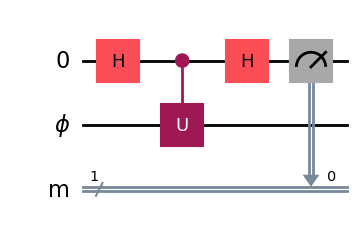

Counts: {'0': 854, '1': 146}


In [12]:
zeroQubit = QuantumRegister(1, '0')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit, cl) 
circuit.h(0)
#circuit.sdg(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

### Inner Product

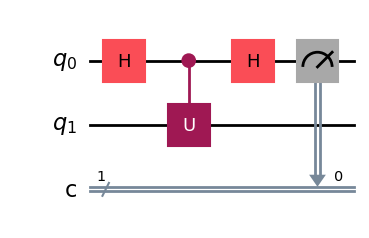

Counts: {'0': 991, '1': 9}


In [13]:
circuit = QuantumCircuit(2, 1) 
circuit.h(0)
a = np.sqrt(3)
b = 1/np.sqrt(2)
UMatrix = b*np.array([[(a+1)/2,(a-1)/2],[(a-1)/2,(-a-1)/2]])
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,100)
print('Counts:',counts)

### Inner Product-Real

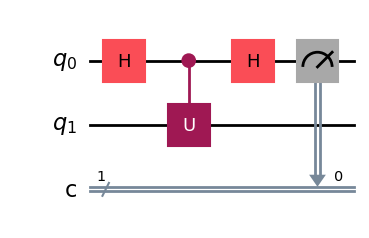

dotprod: -0.8154


In [14]:

U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(np.pi/3)
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = 2*counts['0']/nShots - 1
print('dotprod:',dotprod)

### Inner product: Imaginary

In [15]:

	
U_phi = ryMatrix(2*np.pi/3)
U_psi = rzMatrix(-np.pi)
UMatrix = np.matmul(U_phi.conj().T,U_psi)
phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
circuit.sdg(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
circuit.draw('mpl')
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = (counts['0'] - counts['1'])/nShots
print('dotprod:',dotprod)

Exact: (3.0616169978683836e-17+0.5000000000000001j)
dotprod: 0.0494


### Inner product: Negative Real

Exact: -0.9659258262890684


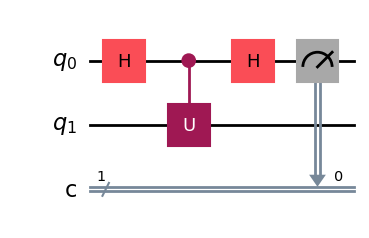

dotprod: -0.097


In [16]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(5*np.pi/2)

phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = (counts['0'] - counts['1'])/nShots
print('dotprod:',dotprod)

### Swap test concept

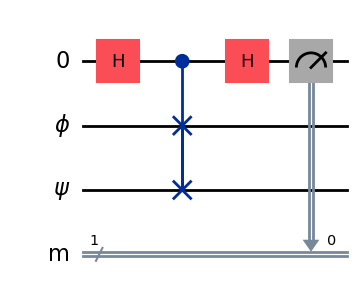

In [17]:
zeroQubit = QuantumRegister(1, '0')
psiQubit = QuantumRegister(1, '\u03C8')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit,psiQubit,cl) 
circuit.h(0)

circuit.cswap(zeroQubit, psiQubit, phiQubit)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 


### Swap test example

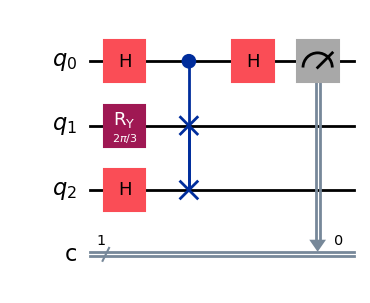

Counts: {'0': 967, '1': 33}
dotprodSqr: -0.8066


In [18]:
circuit = QuantumCircuit(3,1) 
circuit.h(0)
circuit.ry(2*np.pi/3, 1)
circuit.h(2)
circuit.cswap(0, 1, 2)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 
counts = simulateCircuit(circuit,10000)
print('Counts:',counts)

P0 = (counts['0'])/10000
print('dotprodSqr:',2*P0-1)

## Woodbury equation
A demo from the paper " A near-term quantum algorithm for solving linear systems of equations based on the woodbury identity", O'Malley, et. al, 2022. arXiv preprint arXiv:2205.00645.


In [19]:
# Problem: (I + u*v^T)x = b, compute <z|x>
n = 3  # 3 qubits = 8-dimensional vectors

z_prep = hadamards(n)  # Query vector |z>
b_prep = hadamards(n)  # RHS |b>
v_prep = hadamards(n)  # Update |v>
u_prep = hadamards(n)  # Update |u>

# Woodbury parameters
alpha = 1.0
beta = 1.0

# Run quantum algorithm
result = woodbury_rank1_query(
    z_prep, b_prep, v_prep, u_prep, 
    alpha, beta, 
    shots=10
)

print(f"Quantum result: {result:.4f}")
print(f"Expected (analytical): 0.5000")  # For uniform states

Quantum result: 0.5000
Expected (analytical): 0.5000


## Estimating compliance change in 2D FEA

SE of the initial design: 0.1842855019073454
nQubits needed: 11


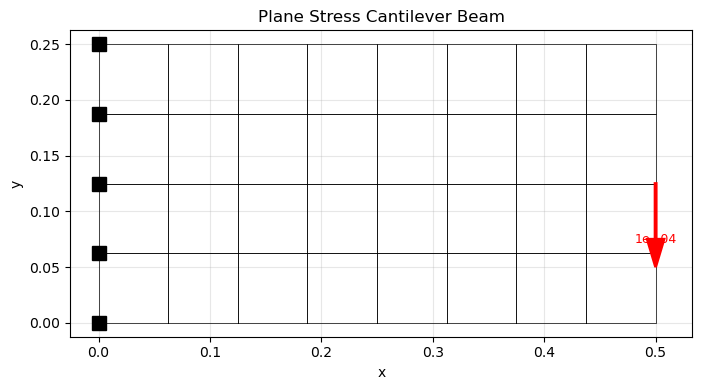

In [20]:
# 1. Define the Problem Scale (Small for demonstration)
nx, ny = 8, 4
fea = PlaneStressCantilever(nx=nx, ny=ny)
xi = np.ones(nx * ny) # Initial design: full material
fea.xi = xi
U, valid = fea.solve()
fea.plot_mesh()
se = fea.compute_elem_strain_energies()
initial_se_sum = np.sum(se)
print("SE of the initial design:", initial_se_sum)
nQubits = 2 * int(np.log2(nx * ny))+1
print("nQubits needed:", nQubits)

## Circuit for inner product


Input bitstring: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Integer value of input bitstring: 2147483519
SE exact : 0.18375169788804474
SE estimate from quantum overlap: 0.0


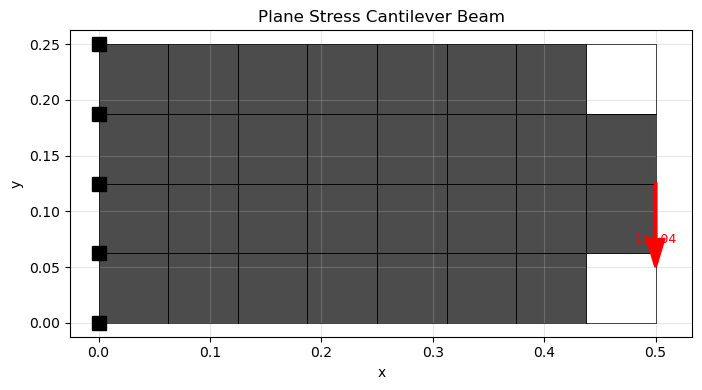

In [21]:
se_norm = np.linalg.norm(se)
se_unit_vector =se/se_norm
test_string = [0 if i in [nx-1, nx*ny -1] else 1 for i in range(nx*ny)]

test_string_norm = np.linalg.norm(test_string)
test_unit_vector = test_string/np.linalg.norm(test_string)
design_idx = sum(bit << i for i, bit in enumerate(test_string))

overlap_squared = inner_product_estimation(se_unit_vector, test_unit_vector, shots = 10000)
SE_new_exact = np.sum(se*test_string)
SE_new_predicted = np.sqrt(overlap_squared)* se_norm * test_string_norm

print("Input bitstring:", test_string)
print("Integer value of input bitstring:", design_idx)
print("SE exact :", SE_new_exact)
print(f"SE estimate from quantum overlap:", SE_new_predicted)

fea.xi = np.array(test_string,float)
fea.plot_mesh()
fea.xi = np.ones(len(se)) # reset design


## Generate best design of desired volume fraction

In [22]:

N = nx * ny
volumeFraction = 0.95
print("Total elements:", N)
K = int(volumeFraction * N)  
print("Desired number of elements:", K)

# The Number of Designs
num_designs = math.comb(N, K)
print(f"Combinatorial search space: {num_designs:,}")
def get_next_bitstring(v):
    """Gosper's Hack: returns the next integer with the same number of set bits."""
    t = (v | (v - 1)) + 1
    return t | ((((t & -t) // (v & -v)) >> 1) - 1)

# Usage:
current_val = (1 << K) - 1  # Smallest integer with desiredNumberOfElements bits set
limit = 1 << N

# This is a generator: it yields one at a time, saving memory
def generate_designs(limit, start_val):
    v = start_val
    while v < limit:
        yield v
        v = get_next_bitstring(v)

best_design = None
for design_idx in generate_designs(limit, current_val):
    bit_string = [(design_idx >> i) & 1 for i in range(N)]
    design_vector = np.array(bit_string)/np.linalg.norm(bit_string)
    ip_estimation = inner_product_estimation(se_unit_vector, design_vector, shots = 10000)
    #ip_estimation = np.dot(se_unit_vector, design_vector)**2
    # Track the best design (smallest overlap)
    if best_design is None:
        ip_best = ip_estimation
        best_design = np.array(bit_string,np.float32) 
    else:
        if ip_estimation > ip_best:
            ip_best = ip_estimation
            se_best = np.sqrt(ip_best)* se_norm * np.linalg.norm(bit_string)
            print(f"*** design_idx {design_idx} se_best:", se_best)
            best_design = np.array(bit_string,np.float32)

print("Best design:", best_design)
print(f"Best SE: {se_best:.4f}")
fea.xi = best_design
fea.plot_mesh()

Total elements: 32
Desired number of elements: 30
Combinatorial search space: 496
Best design: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0.]


NameError: name 'se_best' is not defined